# Bank Conversion Prediction
* **Business Problem:** Our customer, a Bank Institution, wants to optimize sales and their manager's time when selling financial products. The product for this project is a Term Direct Deposit.
  * A **fixed-term** investment where money is deposited into an account at a financial institution. Term deposits are also known as certificates of deposit (CDs) or time deposits. Term deposits typically have higher interest rates than traditional savings accounts, but the funds are not accessible until the term ends.

* **Proposed Solution:** This project aims to create classifier to predict the probability of a customer to convert when offered a financial product (direct term deposit) via a phone call.


* The Dataset can be found in [this link, from UCI DS Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing)

* This project is an example of the use of the framework CRISP-DM in practice.

## Imports

In [ ]:
!pip install category_encoders --quiet
!pip install feature_engine --quiet
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [ ]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Transformations and Modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import category_encoders as ce
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import CategoricalImputer

import warnings
warnings.filterwarnings('ignore')


## Dataset
Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

In [ ]:
!pip install ucimlrepo --quiet
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
df = pd.concat([bank_marketing.data.features, bank_marketing.data.targets], axis=1)
df = df.rename(columns={'day_of_week':'day'})

# View
df.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
36743,37,blue-collar,married,secondary,no,6,yes,no,cellular,12,may,136,2,-1,0,NaN,no
40920,30,blue-collar,single,primary,no,334,no,no,cellular,12,aug,188,1,-1,0,NaN,no
44755,33,admin.,single,secondary,no,555,yes,no,cellular,9,sep,204,1,365,1,success,yes


In [ ]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1),
                                                    df['y'],
                                                    test_size=0.2,
                                                    stratify=df['y'],
                                                    random_state=42)

# train
df_train = pd.concat([X_train, y_train], axis=1)

# test
df_test = pd.concat([X_test, y_test], axis=1)

## [CRISP-DM] Data Understanding

Understanding the data is crucial to a successful project. Getting insights of what drives an output can help us during the modeling phase.

### Statistical Description

Let's start our exploration with the statistical description of our data

In [ ]:
# Statistical description
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,36168.0,NaN,NaN,NaN,40.892999,10.627075,18.0,33.0,39.0,48.0,95.0
job,35934,11,blue-collar,7830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,36168,3,married,21771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,34686,3,secondary,18561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,36168,2,no,35521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,36168.0,NaN,NaN,NaN,1365.49342,3068.5435,-8019.0,74.0,451.0,1430.25,102127.0
housing,36168,2,yes,20182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,36168,2,no,30355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,25782,2,cellular,23465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,36168.0,NaN,NaN,NaN,15.817961,8.33198,1.0,8.0,16.0,21.0,31.0


**Highlights:**
* Age of the customers is 40 years old on average. Distribution skewed to the right.
* More than 20% of the customers are blue-collar workers.
* Most of the customers are married, with secondary level education, own a house loan.
* Only ~2% had payment default.
* Conversion Rate ~ 11.7%

Now let's look at the distribution of our target variable ( *y* )


**Analysis** | The target variable is very unbalanced.

In [ ]:
# Distribution of Y
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df_train, x='y', hue='y')
plt.title('Target Variable : Conversions');
#add % on top of each bar
for pct in ax.patches:
    ax.annotate(f'{round(pct.get_height()/df_train.shape[0]*100,1)}%',
                (pct.get_x() + pct.get_width() / 2, pct.get_height()),
                ha='center', va='bottom')

### Bivariate Plots

####**Age versus Conversion** |
Customers who converted to the campaigns are slightly younger than those who did not. However, both distributions are visually similar, even though the KS Test shows they are statistically different.

In [ ]:
# Age versus Conversion
plt.figure( figsize=(10,5))
ax = sns.boxenplot(data=df_train, x='age', y='y', hue='y', alpha=0.8)
plt.suptitle('Age versus Conversion')
plt.ylabel('Converted')
plt.title('Conversions are concentrated between 30 and 50 years old, which is not that different from the not converted', size=9)

# Annotation
# Medians and Averages
median_converted = df_train.query('y == "yes"')['age'].median()
median_not_converted = df_train.query('y == "no"')['age'].median()
avg_converted = df_train.query('y == "yes"')['age'].mean()
avg_not_converted = df_train.query('y == "no"')['age'].mean()
# Annotation - Insert text with Average and Median for each category
plt.text(95, 0, f"Avg: {round(avg_not_converted,1)} \nMedian: {median_not_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="lightblue", ec="r", lw=0))
plt.text(95, 1, f"Avg: {round(avg_converted,1)} \nMedian: {median_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="orange", ec="r", lw=0));

Testing statistical difference of the samples

In [ ]:
#Sample 1 - Age of the converted customers
converted = df_train.query('y == "yes"')['age']

#Sample 2 - Age of the not converted customers
not_converted = df_train.query('y == "no"')['age']

# Kolmogorov-Smirnov Test
# The null hypothesis is that the two distributions are identical
from scipy.stats import ks_2samp
statistic, p = ks_2samp(converted, not_converted)

if p > 0.05:
    print("The distributions are identical.")
else:
    print("The distributions are not identical: p-value ==", round(p,10))

---
####**job versus Conversions** |
Customers who hold management roles in their jobs are converting more, followed by technicians, blue-collars, admin and retired.

In [ ]:
# job versus Conversions == "YES"
converted = df_train.query('y == "yes"')
plt.figure( figsize=(10,5))
# order of the bars from highest to lowest
order = df_train.query('y == "yes"')['job'].value_counts().index
# Plot and title
ax = sns.countplot(data=converted,
                   x='job',
                   order=order,
                   palette= 5*["#4978d0"] + 6*["#7886a0"])
plt.suptitle('Job versus Converted Customers')
plt.title('Most of the customers who converted are in management jobs. \n75% of the conversions are concentrated in 5 job-categories', size=9);
# X label rotation
plt.xticks(rotation=80);
#add % on top of each bar
for pct in ax.patches:
    ax.annotate(f'{round(pct.get_height()/converted.shape[0]*100,1)}%',
                (pct.get_x() + pct.get_width() / 2, pct.get_height()),
                ha='center', va='bottom')


####**Marital Status versus Conversion** |
Married customers convert more to the term deposit.

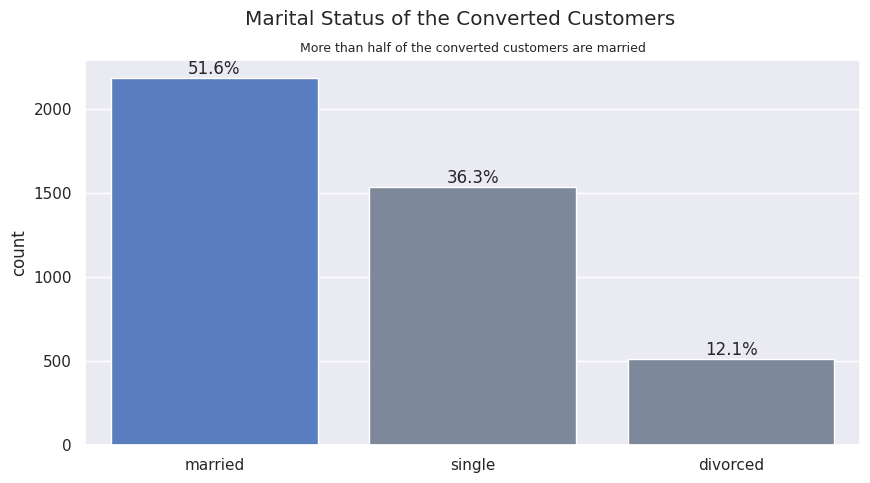

In [ ]:
# Marital Status versus Conversion
converted = df_train.query('y == "yes"')
plt.figure( figsize=(10,5))
ax = sns.countplot(data=converted,
                   x='marital',
                   palette= ["#4978d0", "#7886a0", "#7886a0"],
                   order=df_train.query('y == "yes"')['marital'].value_counts().index)
plt.xlabel('')
plt.suptitle('Marital Status of the Converted Customers')
plt.title('More than half of the converted customers are married', size=9);
#add % on top of each bar
for pct in ax.patches:
    ax.annotate(f'{round(pct.get_height()/converted.shape[0]*100,1)}%',
                (pct.get_x() + pct.get_width() / 2, pct.get_height()),
                ha='center', va='bottom')

---
####**Education versus Conversion** |
More educated people convert more to a financial product. However, the converted distribution follows the dataset distribution, so this variable will probably not differentiate conversions from not conversions.

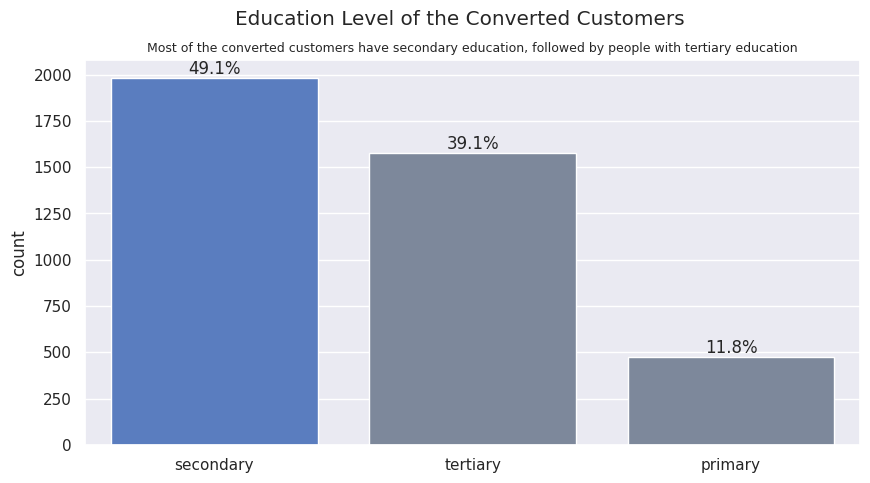

In [ ]:
#Education versus Conversion
converted = df_train.query('y == "yes"').dropna(subset='education')
plt.figure( figsize=(10,5))
ax = sns.countplot(data=converted,
                   x='education',
                   order=df_train.query('y == "yes"')['education'].value_counts().index,
                   palette= ["#4978d0", "#7886a0", "#7886a0"])
plt.xlabel('')
plt.suptitle('Education Level of the Converted Customers')
plt.title('Most of the converted customers have secondary education, followed by people with tertiary education', size=9);
#add % on top of each bar
for pct in ax.patches:
    ax.annotate(f'{round(pct.get_height()/converted.shape[0]*100,1)}%',
                (pct.get_x() + pct.get_width() / 2, pct.get_height()),
                ha='center', va='bottom')

In [ ]:
(
    df_train #data
    .education #variable
    .value_counts(normalize=True) #percentages of total
    .reset_index() #reset index
    .rename(columns={'proportion':'pct_total'}) #rename columns
    .merge( df_train.query('y == "yes"').education.value_counts(normalize=True).rename('pct_converted'),
            on='education')
)

---
####**Balance versus Conversions** |
Customers with a higher balance on their account are converting more. We tested the statistical significance of the samples and there is a difference.

In [ ]:
# Subplots
plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Balance versus Conversions with 98% of the data
plt.subplot(1,2,1)
converted = df_train.query(f'y == "yes" & balance <= {np.quantile(df_train.balance,0.98)}')
ax1 = sns.kdeplot(data=converted, x='balance', color='orange')
plt.suptitle('Balance versus Conversion')
plt.title('Customers Converted', size = 9);

# Balance versus NOT Conversions with 98% of the data
plt.subplot(1,2,2)
converted = df_train.query(f'y == "no" & balance <= {np.quantile(df_train.balance,0.98)}')
ax2 = sns.kdeplot(data=converted, x='balance')
plt.suptitle('Balance versus Conversion')
plt.title('Customers Not Converted ', size = 9);

In the previous plot, we arbitrarily removed the data points over the 98th percentile, so the visualization was better. We can see that the converted customers have higher balances, in general, but we can't tell if there is a  statistical difference between both groups. Let's test that.
Given that the distributions are heavily skewed to the right, we will use a non-parametric test, the **Kolmogorov-Smirnov Test**

In [ ]:
#Sample 1 - Balance of the converted customers
converted = df_train.query('y == "yes"')['balance']

#Sample 2 - Balance of the not converted customers
not_converted = df_train.query('y == "no"')['balance']

# Kolmogorov-Smirnov Test
# The null hypothesis is that the two distributions are identical
from scipy.stats import ks_2samp
statistic, p = ks_2samp(converted, not_converted)

if p > 0.05:
    print("The distributions are identical.")
else:
    print("The distributions are not identical: p-value ==", round(p,4))

In [ ]:
# Are there people with negative balance converting to a term deposit?
neg_converted = df_train.query('y == "yes" & balance < 0').y.count()
pct = round(neg_converted/df_train.query('y == "yes"').y.count()*100,1)
print(f'There are {neg_converted} conversions from people with negative acct balance. \nThis represents {pct}% of the total count of customers converted.')

---
####**Duration versus Conversions** |
In this plot, we can visually notice the impact of the duration of the phone calls on the conversions. Customers who converted stayed twice or more time in the call than the other customers.

In [ ]:
# Duration versus Converted
plt.figure( figsize=(10,5))
ax = sns.boxenplot(data=df_train, x='duration', y='y', hue='y', alpha=0.9)
plt.ylabel('Converted')
plt.xlabel('Phone call duration in seconds')
plt.suptitle('Duration versus Conversion')
plt.title('There is a strong influence of the duration of the phone call with the conversion. \nCustomers converted had much longer calls on average than those who did not convert.', size=9)
# Annotation
# Medians and Averages
median_converted = df_train.query('y == "yes"')['duration'].median()
median_not_converted = df_train.query('y == "no"')['duration'].median()
avg_converted = df_train.query('y == "yes"')['duration'].mean()
avg_not_converted = df_train.query('y == "no"')['duration'].mean()
# Annotation - Insert text with Average and Median for each category
plt.text(4000, 0, f"Avg: {round(avg_not_converted,1)} \nMedian: {median_not_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="lightblue", ec="r", lw=0))
plt.text(4000, 1, f"Avg: {round(avg_converted,1)} \nMedian: {median_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="orange", ec="r", lw=0));

---
####**Campaign Contacts versus Conversions** |
People who converted received between 2 to 4 contacts, in general. After the 5th contact, the points for *converted* start to become sparse. For *Not converted*, the points are more consistent through 13 contacts or so.

In [ ]:
# Campaign Contacts versus Converted
plt.figure( figsize=(10,5))
# ax = sns.boxenplot(data=df_train.query('campaign < 11'), x='campaign', y='y', hue='y', alpha=0.9)
ax = sns.catplot(data=df_train.query('campaign < 21'), x='campaign', y='y', hue='y', alpha=0.4, jitter=.4)
plt.ylabel('Converted')
plt.xlabel('Number of contacts performed during this campaign')
plt.title('Campaign Contacts versus Conversion');

# Annotation
# Medians and Averages
median_converted = df_train.query('y == "yes"')['campaign'].median()
median_not_converted = df_train.query('y == "no"')['campaign'].median()
avg_converted = df_train.query('y == "yes"')['campaign'].mean()
avg_not_converted = df_train.query('y == "no"')['campaign'].mean()
# Annotation - Insert text with Average and Median for each category
plt.text(24, 0, f"Not Convert\nAvg: {round(avg_not_converted,1)} \nMedian: {median_not_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="lightblue", ec="r", lw=0))
plt.text(24, 1, f"Convert\nAvg: {round(avg_converted,1)} \nMedian: {median_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="orange", ec="r", lw=0));

---
####**Previous Contacts versus Converted** |
It appears that more previous contacts can influence the customer to convert. We notice in the graphic that the converted customers received a couple more calls than the not converted.

In [ ]:
# Previous Contacts versus Converted
plt.figure( figsize=(10,5))
ax = sns.boxenplot(data=df_train.query('previous < 25'), x='previous', y='y', hue='y', alpha=0.9)
plt.ylabel('Converted')
plt.xlabel('Number of contacts performed before this campaign')
plt.suptitle('Prior Campaign Contacts versus Conversion')
plt.title('More prior contacts can impact in the conversion rate', size=9);

# Annotation
# Medians and Averages
median_converted = df_train.query('y == "yes"')['previous'].median()
median_not_converted = df_train.query('y == "no"')['previous'].median()
avg_converted = df_train.query('y == "yes"')['previous'].mean()
avg_not_converted = df_train.query('y == "no"')['previous'].mean()
# Annotation - Insert text with Average and Median for each category
plt.text(22, 0, f"Avg: {round(avg_not_converted,1)} \nMedian: {median_not_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="lightblue", ec="r", lw=0))
plt.text(22, 1, f"Avg: {round(avg_converted,1)} \nMedian: {median_converted}",
         ha="center", va="center", rotation=0,
         size=9, bbox=dict(boxstyle="roundtooth, pad=0.5", fc="orange", ec="r", lw=0));

---
####**Previous Campaign Outcome versus Conversion** |
Customers who converted in the past are more inclined to convert again. Likewise, customers with past failures tend to repeat the failure.

In [ ]:
# Previous Campaign Outcome versus Conversion
plt.figure( figsize=(10,5))
ax = sns.countplot(data=df_train, x='poutcome', hue='y', palette= ["#4978d0", "#7886a0"], )
plt.suptitle('Previous Campaign Outcome versus Conversion')
plt.title('Previous campaign success customers are more inclined to repeat the conversion', size=9);

---
####**Contact Method versus Conversion** |
Despite there is more conversions from customers contacted via cell phone, it just shows that there are less landlines. The proportions of conversion are similar from both types of contact.

In [ ]:
# Contact Method versus Conversion
plt.figure( figsize=(10,5))
ax = sns.countplot(data=df_train, x='contact', hue='y', palette= ["#4978d0", "#7886a0"])
plt.suptitle('Contact Method versus Conversion')
plt.title('More conversions from cell phone', size=9);

In [ ]:
# Proportion of conversions by contact
(
    df_train
    .groupby('contact')
    ['y']
    .value_counts(normalize=True)
)

---
####**Month versus Conversions** |
There are more conversions on the mid-year months, however, ~76% of the calls were made on those months. Possibly the campaign ran more heavily during those months.

In [ ]:
# Month versus Conversions
plt.figure( figsize=(10,5))
ax = sns.countplot(data=df_train.query('y == "yes"'), x='month',
                   palette= ["#7886a0", "#7886a0", "#7886a0", "#4978d0", "#4978d0","#4978d0","#4978d0","#4978d0", "#7886a0", "#7886a0", "#7886a0", "#7886a0"])
plt.suptitle('Month versus Conversion')
plt.title('More conversions on the mid-year months, but there are more contacts in mid-year as well', size=9);

In [ ]:
# Percentage of calls by month
pct_calls_by_month = (
    df_train #dataset
    .groupby('month') #group by month
    .month.value_counts() # count values by months
    .reset_index()
    .rename(columns={'count':'ct'})
    .assign(pct_calls = lambda x: x.ct/x.ct.sum())
    [['month', 'pct_calls']]
)

(df_train #data
 .groupby('month') #group
 .y #column to aggregate
 .value_counts(normalize=True) #aggregation
 .reset_index() #reset index
 .rename(columns={'proportion':'conversion_rate'}) #rename col
 .pivot(index='month', columns = 'y', values='conversion_rate') #pivot for merging
 .merge(pct_calls_by_month, on='month', how='left') #merge (left join)
 .assign(col_order = [4,8,12,2,1,7,6,3,5,11,10,9]) #index to reorder by month
 .sort_values('col_order') #arrange
 .drop(columns='col_order')
 .style
 .bar(subset=['pct_calls'], color='#7886a0') #add bar
 )

---
####**Day versus Conversions** |
The conversions happen more around the most probable payment days 5, 15 and 30. We can notice higher peaks around these dates.

In [ ]:
df_train.query('y == "yes"').day.value_counts().sort_index().plot.bar(figsize=(12,4));

In [ ]:
(df_train #dataset
 .groupby(['y']) # group by conversion (Y/N)
 .day #variable to aggregate
 .value_counts() #count values
 .reset_index()
 .rename(columns={'count':'ct'})
 .groupby('y') #group again
 .apply(lambda x: x.nlargest(6, 'ct'))
 )

---
####**pdays versus Conversions** |
Most of the conversions happened for customers contacted within the past 100 days from a previous campaign

In [ ]:
# pdays versus Conversions
plt.figure( figsize=(16,4))
sns.boxenplot(data=df_train, x='pdays', hue='y', dodge=True, alpha=0.9)
plt.suptitle('Days Since Last Contact from Previous Campaign')
plt.title('Most of the conversions happened for customers contacted within the past 100 days from a previous campaign', size=9);

Most of the conversions are made in the first contact.

In [ ]:
# The impact of the recency of the contact over conversions
total = df_train.query('y == "yes"').y.count()
print('First contact:', round( df_train.query('y == "yes" & pdays == -1').y.count()/total*100, 0 ), '%')
print('Up to 180 days:', round( df_train.query('y == "yes" & pdays > 0 & pdays <= 180').y.count()/total*100, 0 ), '%')
print('More than 180 days:', round( df_train.query('y == "yes" & pdays > 180').y.count()/total*100, 0 ), '%')

In [ ]:
# The impact of the recency of the contact over Not converted
total = df_train.query('y == "no"').y.count()
print('First contact:', round( df_train.query('y == "no" & pdays == -1').y.count()/total*100, 0 ), '%')
print('Up to 180 days:', round( df_train.query('y == "no" & pdays > 0 & pdays <= 180').y.count()/total*100, 0 ), '%')
print('More than 180 days:', round( df_train.query('y == "no" & pdays > 180').y.count()/total*100, 0 ), '%')

The probablility of conversion decreases for customers previously contacted more than 10 times.

In [ ]:
# How many contacts does it take to convert those not converted on the first contact
(
    df_train
    .query('pdays != -1')
    .groupby('previous')
    .y
    .value_counts()
    .reset_index()
    .rename(columns={'count':'ct'})
    .pivot(index='previous', columns='y', values='ct')
    .fillna(0)
    .assign(total = lambda x: x.no + x.yes)
    .assign(pct_no = lambda x: x.no/x.total)
    .assign(pct_yes = lambda x: x.yes/x.total)
    .reset_index()
    .head(25)
    .plot(x='previous', y=['pct_yes','pct_no'], sharex=True, figsize=(10,5))
    );

In [ ]:
print("Number of contacts for Existing Customers (Customers previously contacted)")
print(df_train.query('y == "yes" & pdays != -1').campaign.mean())
print()
print("Number of contacts for New Leads, never contacted")
print(df_train.query('y == "yes" & pdays == -1').campaign.mean())


---
**Housing versus Conversions** | There are more conversions from people wihtout house loan - 1.7 times more conversions.

In [ ]:
# Housing versus Conversions
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_train, x='housing', hue='y', palette= ["#4978d0", "#7886a0"])
plt.suptitle('Housing Loan versus Conversion')
plt.title('More conversions from customers without housing loans', size=9);
# Annotation
for v in ax.patches:
    ax.annotate(f'{round(v.get_height())}',
                (v.get_x() + v.get_width() / 2, v.get_height()),
                ha='center', va='bottom')

---
**Personal Loan versus Conversions** | There are more conversions from people without peprsonal loans. Although it follows the overall distribution, people without loan are proportionally higher conversions.

In [ ]:
# Loan versus Conversions
plt.figure(figsize=(10,5))
ax=sns.countplot( data=df_train,
              x='loan', hue='y',
              palette= ["#4978d0", "#7886a0"])
plt.suptitle('Loan versus Conversion')
plt.title('More conversions from customers without loans, but data is just following the distribution', size=9);
#add % on top of each bar
for pct in ax.patches:
    ax.annotate(f'{pct.get_height()}',
                (pct.get_x() + pct.get_width() / 2, pct.get_height()),
                ha='center', va='bottom')

---
**default versus conversion** | Conversions are almost entirely from people without payment defaults, what makes sense, as those with default are probably without money. People without default is converting twice more as those with default.

In [ ]:
# plot default versus conversion
plt.figure(figsize=(10,5))
sns.countplot(data=df_train, x='default', hue='y', palette= ["#4978d0", "#7886a0"])
plt.suptitle('Default versus Conversion')
plt.title('Almost all the conversions are from customers without default.', size=9);

In [ ]:
# Numbers of conversions by Default type
(df_train #data
 .groupby('default')['y'] #group by default
 .value_counts() #count values of y
 .reset_index() #reset index
 .rename(columns={'count':'ct'}) #rename count column
 .merge( df_train.groupby('default').y.value_counts(normalize=True).rename('pct'),
         on=['default', 'y'])
)

### Exploration Summary
After thorough exploration of the data, we can summarize it as follows:
* The converter profile is a 38 to 41 year old person, working on a management role, married, with a refined education of at least secondary level, holding a positive balance on their account without housing or personal loan, thus with less debt.
* Most conversions happened on the first contact.
* Customers not converted on the first contact received something between 2 to 4 contacts before conversion.
* The more contacts from this campaign, the lower the probability of a customer have converted.
* Customers never contacted before need more contacts on average than existing customers
* There are more chances of conversion for people contacted up to 10 times for previous campaign.
* Contacts from previous campaigns can impact on the conversion of the current campaign, possibly indicating that relationship over time matters.
* Customers that converted in previous campaigns are more likely to repeat conversion, while failure to convert also show a tendency to not convert again.
* The longer the contacts, the higher the chance of converting. People who converted stayed connected to the call up to 4 times more seconds. However, we can't use the duration of the call as a predictor.

Looking at the graphics after exploration, the variables `duration`, `job`, `marital`, `balance`, `previous`, `campaign`, `default`, `housing` and `loan` are interesting for modeling, as they impact more directly on the target variable. However, `duration` cannot be used, as it is not possible to know the duration of a phone call until it ends. The variable `poutcome` also looks promising, but it has too many *NAs*, so it  needs further treatment to be considered.

### Decision Tree for Exploratory Purposes
We can use Decision Trees to check how the variables interact to each other to produce the final outcome, the target variable *y*.

First, we will quickly transform the dataset to encode the categorical variables, so we can run the decision tree. For that, we will use the catboost encoder in a `sklearn` Pipeline.

In [ ]:
# Binarize target variable
y_train = y_train.replace({'no':0, 'yes':1})

# Categorical Columns
cat_cols = X_train.select_dtypes(include='object').columns

# Steps for Pipeline
steps = [
    ('encode', ce.CatBoostEncoder(cols=cat_cols)),
    ('model', DecisionTreeClassifier(max_depth=4, max_features=4))
]

# Create Pipeline
pipe = Pipeline(steps)

# Fit
pipe.fit(X_train, y_train)

Next, we are checking for the most important variables to this model using permutation importance. It looks like the model is relying heavily on `poutcome`, what was somewhat expected. Remember that during our visualization we saw that the customers that converted in the past had tendency to convert again, and so the failures to become failure again.

A surprise was seeing `pdays` as an important variable, since the graphic did not bring much insight.

In [ ]:
# Get model from pipeline
model = pipe['model']

# Transform X categorical variables to encoded variables
X = ce.CatBoostEncoder(cols=cat_cols).fit_transform(X_train, y_train)

# Importances
importance = permutation_importance(model, X, y_train,
                                    n_repeats=20,
                                    random_state=12)

# Sort importances
sorted_importances = np.sort(importance.importances_mean)

# Plot importances
plt.barh(y=X_train.columns, width=sorted_importances);

Now let us include only the selected columns.

In [ ]:
# Columns to include in the analysis
cols = ['duration', 'job', 'marital', 'balance', 'previous', 'housing', 'loan', 'poutcome', 'campaign', 'pdays', 'default']

# X including only the columns previously chosen
X = X_train[cols]

# Categorical Columns
cat_cols = X.select_dtypes(include='object').columns

# Steps for Pipeline
steps = [
    ('encode', ce.CatBoostEncoder(cols=cat_cols)),
    ('model', DecisionTreeClassifier(max_depth=4))
]

# Create Pipeline
pipe2 = Pipeline(steps)
#Fit
pipe2.fit(X, y_train)

In [ ]:
# Get model from pipeline
model2 = pipe2['model']

# Transform X categorical variables to encoded variables
X = ce.CatBoostEncoder(cols=cat_cols).fit_transform(X, y_train)[cols]

# Importances
importance = permutation_importance(model2, X, y_train,
                                    n_repeats=40,
                                    random_state=12)

# Sort importances
sorted_importances = np.sort(importance.importances_mean)

# Plot importances
plt.barh(y=X.columns, width=sorted_importances)
plt.title('Features Importances');

Next, this *Decision Tree* can help us getting some extra insights about the variables interactions.
* Despite `duration` does not figure as the top important variable, it still helps to separate the outcomes. Notice that whenever `duration` is higher, the outcome tend to be **Yes**.
* Lower `poutcome` drives classification towards **No**.


In [ ]:
# Plot Tree from Pipeline
plt.figure(figsize=(22,12))
plot_tree(pipe2['model'],
          max_depth=4,
          feature_names=X.columns,
          class_names=['no', 'yes'],
          filled=True);

## [CRISP-DM] Data Preparation

Now that we understood the data and got the initial insights, let's move on preparing the data for modeling.

### Removing Missing Data

In [ ]:
# Checking for missing data
df_train.isna().sum()[df_train.isna().sum() > 0]

,0
job,234
education,1482
contact,10386
poutcome,29589


In [ ]:
# NAs in job
(df_train #data
 .query('job != job') # only NAs
 .groupby('y') #group by target var
 ['y']
 .count() #count values
 )

,y
y,
no,206
yes,28


Starting with `job`, we see that there are 28 converted customers that would be lost (0.6%) if we drop those NAs. There would be three options in this case:
1. Drop the NAs: only 0.6% may not make a difference
2. Use Random Forest to predict what is the job.
3. Add the most frequent job, which is *blue collar*.

We will move on with drop, at this time, as we consider the number too small to be worth it to predict a job.

In [ ]:
# Check the impact of NAs for the job variable in the conversions
df_train.query('job != job').groupby('y')['y'].value_counts()

# Drop NAs.
df_train_clean = df_train.dropna(subset='job')

# Checking for deletion of the missing values
df_train_clean.job.isna().sum()

0

Next, looking at `education` missing values.
There are 1482 missing entries and 196 of those are **Yes**, which represents 4.6% of the converted customers. In this case, it is a considerable amount of converted observations to be dropped.

In this case, we are going to use the `SimpleImputer` input the most frequent category for the education of these NAs.

In [ ]:
# NAs in education
# (df_train #data
#  .query('education != education') # only NAs
#  .groupby('y') #group by target var
#  ['y']
#  .count() #count values
#  )

In [ ]:
# Check the impact of NAs for the job variable in the conversions
df_train.query('education != education').groupby('y')['y'].value_counts()

# Simple Imputer
imputer = CategoricalImputer(
    variables=['education'],
    imputation_method="frequent"
)

# Fit and Transform
imputer.fit(df_train_clean)
df_train_clean = imputer.transform(df_train_clean)

# Checking for deletion of the missing values
df_train_clean.education.isna().sum()

0

For `poutcome`, we must come up with a new category. So this variable shows what is the result of a previous marketing campaign. According to our insight in the exploration phase, customers that converted in the past are more likely to convert again. So this variable becomes interesting to the model. However, there are a lot of missing values that will need to go to a separate category, so we won't bias our model with inputation of the vast majority of the data.
We will input *"unknown"* for the NAs.

In [ ]:
df_train_clean.poutcome.value_counts(dropna=False)

,count
poutcome,
NaN,29384
failure,3872
other,1483
success,1195


In [ ]:
# Input "unknown" for NAs.
df_train_clean['poutcome'] = df_train_clean['poutcome'].fillna('unknown')

# Checking for deletion of the missing values
df_train_clean.poutcome.isna().sum()

0

For `contact` we will add *"unknown"* to the NAs, just like the data documentation says.

In [ ]:
# Fill NAs with "unknown"
df_train_clean['contact'] = df_train_clean['contact'].fillna('unknown')

In [ ]:
# Checking all the variables after missing data removed
df_train_clean.isna().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check version for evaluation of the predictions
df_check = df_train_clean.copy()

### Categorical Data transformation

Many models don't deal well with categorical data. Therefore, we need to transform the data to numbers using an encoding type. Here is the strategy to be used for this project:
* `education`, `contact`, `balance`, `marital`, `job`,  and `poutcome`: For these variables, One Hot Encoding can be ideal.
* `default`, `housing`, `loan`, and `y` are binary variables that will be mapped to **no: 0** and **yes: 1**.

In [ ]:
# View clean data
df_train_clean.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
14910,29,services,married,secondary,no,249,yes,no,cellular,16,jul,346,2,-1,0,unknown,no
34400,59,blue-collar,married,primary,no,6212,yes,no,cellular,5,may,574,2,-1,0,unknown,no
134,28,unemployed,single,tertiary,no,0,yes,no,unknown,5,may,125,2,-1,0,unknown,no


In [ ]:
# Binarizing default, housing, loan, and y
df_train_clean = df_train_clean.replace({'no': 0, 'yes': 1})

In [ ]:
# Balance in 3 categories: <0 = 'negative, 0-median = 'avg', >median = 'over avg'
df_train_clean = (
    df_train_clean
    .assign(balance = lambda x: np.where(x.balance < 0,
                                          'negative',
                                          np.where(x.balance < x.balance.median(),
                                                   'avg',
                                                   'over avg')
                                          )
    )
)



In [ ]:
# One Hot Encoding for 'marital', 'poutcome', 'education', 'contact', 'job', 'balance'
from feature_engine.encoding import OneHotEncoder

# Instance
ohe = OneHotEncoder(variables=['marital', 'poutcome', 'education', 'contact', 'job', 'balance'], drop_last=True)

# Fit
ohe.fit(df_train_clean)

# Transform
df_train_clean = ohe.transform(df_train_clean)

# Move y to the first column
df_train_clean.insert(0, 'y', df_train_clean.pop('y'))

`month` to numerical variable

In [ ]:
# Month to numbers
df_train_clean['month'] = df_train_clean['month'].map({ 'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})

Numerical Variables to categories (bins)

In [ ]:
# Function to replace the variable data with the new categorized bins
def variable_to_category(data, variable, k):
  return pd.cut(data[variable], bins=k).astype(str)

In [ ]:
# Transforming variable Age into bins
# Using Sturges rule, where number of bins k = 1 + 3.3*log10(n)
k = int( 1 + 3.3*np.log10(len(df_train_clean)) )

# Categorize age, balance, duration, previous, pdays
for var in str.split('age,pdays,previous', sep=','):
  df_train_clean[var] = variable_to_category(df_train_clean, var, k=k)

In [ ]:
# CatBoost Encoding the dataset
df_train_clean = ce.CatBoostEncoder().fit_transform(df_train_clean, df_train_clean['y'])

In [ ]:
# View of the final dataset for modeling
df_train_clean.sample(5)

,y,age,default,housing,loan,day,month,duration,campaign,pdays,...,job_unemployed,job_blue-collar,job_management,job_services,job_admin.,job_retired,job_entrepreneur,job_housemaid,balance_over avg,balance_avg
38940,0,0.094159,0,1,0,18,5,176,1,0.093098,...,0,1,0,0,0,0,0,0,0,0
18669,0,0.087741,0,1,0,31,7,7,2,0.095821,...,0,0,1,0,0,0,0,0,1,0
26518,1,0.091645,0,1,0,20,11,562,2,0.093281,...,0,0,1,0,0,0,0,0,0,1
1104,0,0.118769,0,0,0,7,5,127,2,0.094197,...,0,0,0,1,0,0,0,0,1,0
42686,0,0.179120,0,0,0,15,1,99,2,0.076758,...,0,0,0,0,1,0,0,0,1,0


## [CRISP-DM] Modeling
Once the data is prepared and transformed, we can start modeling.

For this modeling, we are going to start testing many algorithms to see which one performs best. Knowing that the data has a huge unbalance with 88% of the observations classified as *no*, we will use weights for the classes.

In [ ]:
# X and y sample for testing models
df_sample = df_train_clean.sample(5_000)
X = df_sample.drop(['y', 'duration'], axis=1)
y = df_sample['y']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Define a function to test multiple classifiers
def test_classifiers(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Dictionary of classifiers to test
    classifiers = {
        "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
        "Random Forest": RandomForestClassifier(class_weight='balanced'),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Support Vector Machine": SVC(class_weight='balanced', probability=True),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Catboost": CatBoostClassifier(iterations=2000, depth=5, learning_rate=0.5,
                           loss_function='Logloss', class_weights=[1, 3],  early_stopping_rounds=50, verbose=False),
        "AdaBoost": AdaBoostClassifier(),
        "Extra Trees": ExtraTreesClassifier(class_weight='balanced'),
        "XGBoost": XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
    }

    # Store results
    results = []

    # Iterate over classifiers
    for clf_name, clf in classifiers.items():
        # Train the classifier
        clf.fit(X_train, y_train)

        # Predict on the test set
        y_pred = clf.predict(X_test)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred, average="weighted")

        # Perform cross-validation for a more robust evaluation
        cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1_weighted").mean()

        # Append results
        results.append({
            "Classifier": clf_name,
            "F1 Score": f1,
            "Cross-Validated F1 Score": cv_f1
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="Cross-Validated F1 Score", ascending=False).reset_index(drop=True)

    return results_df

# Example of using the function with your dataset
results = test_classifiers(X, y)
print(results)


               Classifier  F1 Score  Cross-Validated F1 Score
0                Catboost  0.850540                  0.853871
1       Gradient Boosting  0.854489                  0.849213
2                 XGBoost  0.850632                  0.849154
3     K-Nearest Neighbors  0.849259                  0.848444
4             Extra Trees  0.848394                  0.846552
5                AdaBoost  0.846331                  0.841090
6           Random Forest  0.838153                  0.840768
7           Decision Tree  0.818133                  0.814410
8     Logistic Regression  0.752056                  0.750190
9  Support Vector Machine  0.712686                  0.722281


The best performing models for this problem were the Boosting ones. `CatBoost` was the top estimator, so we will work with it from now on.

In [ ]:
# Split X and y
X = df_train_clean.drop(['y', 'duration'], axis=1)
y = df_train_clean['y']

# Split Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Let us begin with a base model with all the columns to try to tune it from that starting point.

In [ ]:
model = CatBoostClassifier(verbose=False)
# train the model
model.fit(X_train, y_train)

prediction = model.predict(X_val)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_val, prediction)  )
print ("Confusion Matrix : \n")
display(cm)

# Evaluate the weighted model
print('Base Model:')
print(classification_report(y_val, prediction))

Confusion Matrix : 



,0,1
0,6255,121
1,619,192


Base Model:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6376
           1       0.61      0.24      0.34       811

    accuracy                           0.90      7187
   macro avg       0.76      0.61      0.64      7187
weighted avg       0.88      0.90      0.88      7187



#### Tuning the Model
* `border_count`: Controls the number of binning thresholds for numeric features. Lower values (e.g., 32 or 64) can reduce overfitting, which may help the model generalize better on imbalanced data.

* `l2_leaf_reg`: Adds L2 regularization to the model. Higher values (e.g., 5 or 7) can penalize the model, reducing its complexity and potentially preventing it from being overly biased toward the majority class.

* `depth`: Controls how deep the decision tree should go for classification.
* `learning_rate`: how large is the step of the learning for each iteration when adjusting the weights of the algorithm.
* `class_weights`: good for unbalanced data, we can give a higher weight for the minority class.

In [ ]:
# X and y sample for testing models
df_sample = df_train_clean.sample(5_000)
X = df_sample.drop(['y', 'duration'], axis=1)
y = df_sample['y']

# Train and Test
train_sample, val_sample, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42)

model5 = CatBoostClassifier(iterations=300,
                           eval_metric='F1',
                           early_stopping_rounds=50,
                           verbose=False)

# Define parameter grid
param_grid = {
    'learning_rate': [0.1, 0.5],
    'depth': [4, 5],
    'class_weights': [[1, 3], [1,7]],
    'border_count': [32, 64],
    'l2_leaf_reg': [1, 5, 9]
}

# Run grid search
grid_search = GridSearchCV(model5, param_grid, cv=5)
grid_search.fit(train_sample, train_y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'border_count': 32, 'class_weights': [1, 3], 'depth': 5, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


Next, we try to tweaked the model

In [ ]:
# Tuning the estimator
model2 = CatBoostClassifier(iterations=300,
                            depth=5,
                            learning_rate=0.1,
                            loss_function='Logloss',
                            eval_metric='F1',
                            class_weights={0: 1, 1: 3},
                            border_count= 64,
                            l2_leaf_reg= 13,
                            early_stopping_rounds=50,
                            verbose=1000)

# train the model
model2.fit(X_train, y_train)

prediction2 = model2.predict(X_val)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_val, prediction2)  )
print ("Confusion Matrix : \n")
display(cm)

# # Evaluate the weighted model
print('Tuned Catboost:')
print(classification_report(y_val, prediction2))
print('F1:', accuracy_score(y_val, prediction2))
print('Accuracy:', f1_score(y_val, prediction2))

0:	learn: 0.3781585	total: 21ms	remaining: 6.27s
299:	learn: 0.6217005	total: 10.5s	remaining: 0us
Confusion Matrix : 



,0,1
0,5999,377
1,448,363


Tuned Catboost:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6376
           1       0.49      0.45      0.47       811

    accuracy                           0.89      7187
   macro avg       0.71      0.69      0.70      7187
weighted avg       0.88      0.89      0.88      7187

F1: 0.8852094058717128
Accuracy: 0.46808510638297873


### Selecting the Columns for Modeling
According to our data exploration, the variables that look more promissing are:  `duration`, `job`, `marital`, `balance`, `previous`, `housing`, `loan` and `poutcome`.

Let's run a Recursive Feature Elimination to check if that matches with what we found out.

In [ ]:
# X and y sample for testing models
df_sample = df_train_clean.sample(10_000)
X = df_sample.drop(['y'], axis=1)
y = df_sample['y']

# Train and Test
train_sample, val_sample, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline steps
steps = [
    ('RFE', RFECV(estimator=DecisionTreeClassifier(max_depth=4, class_weight='balanced'),
                  cv=StratifiedKFold(n_splits=5),
                  scoring="f1",
                  min_features_to_select=15))
]

# Pipeline to encode variables and run RFE
rfe_pipe = Pipeline(steps).fit(train_sample, train_y)

In [ ]:
# Selected columns and ranking where selected is true
pd.DataFrame({
    'variable':df_train_clean.drop('y', axis=1).columns,
    'selected':rfe_pipe['RFE'].support_,
    'ranking':rfe_pipe['RFE'].ranking_
}).sort_values('ranking').query('selected == True')['variable'].tolist()


['poutcome_failure',
 'job_unemployed',
 'job_blue-collar',
 'poutcome_unknown',
 'job_management',
 'previous',
 'job_student',
 'pdays',
 'duration',
 'month',
 'day',
 'housing',
 'job_services',
 'campaign',
 'job_technician']

In [ ]:
# Only selected variables
# df_train_selected = df_train_clean.drop(['age', 'education', 'day_of_week','contact', 'month', 'campaign','pdays'], axis=1)

df_train_selected = df_train_clean[['age',  'job_admin.', 'job_services', 'job_management', 'job_blue-collar', 'job_unemployed', 'job_student', 'job_technician',
                                    'contact_cellular', 'contact_telephone', 'job_retired', 'poutcome_failure', 'poutcome_other', 'marital_single', 'marital_divorced',
                                    'previous', 'pdays', 'campaign', 'month', 'day', 'loan', 'housing', 'default', 'poutcome_unknown', 'y']]

print("These are columns to be used during the modeling process:\n")
df_train_selected.columns

These are columns to be used during the modeling process:



Index(['age', 'job_admin.', 'job_services', 'job_management',
       'job_blue-collar', 'job_unemployed', 'job_student', 'job_technician',
       'contact_cellular', 'contact_telephone', 'job_retired',
       'poutcome_failure', 'poutcome_other', 'marital_single',
       'marital_divorced', 'previous', 'pdays', 'campaign', 'month', 'day',
       'loan', 'housing', 'default', 'poutcome_unknown', 'y'],
      dtype='object')

In [ ]:
# Split X and y
Xs = df_train_selected.drop(['y'], axis=1)
ys = df_train_selected['y']

# Split Train and Validation
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs, ys, test_size=0.2, random_state=42)

model3 = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth = 5,
                           loss_function='Logloss',
                           border_count= 64,
                           l2_leaf_reg= 13,
                           class_weights=[1, 3],
                           early_stopping_rounds=50,
                           verbose=1000)
# train the model
model3.fit(Xs_train, ys_train)

prediction3 = model3.predict(Xs_val)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(ys_val, prediction3)  )
print ("\nConfusion Matrix : \n")
display(cm)

# Evaluate the model
print('Catboost Selected Variables:')
print(classification_report(ys_val, prediction3))

0:	learn: 0.6621697	total: 8.75ms	remaining: 2.62s
299:	learn: 0.4165835	total: 4.74s	remaining: 0us

Confusion Matrix : 



,0,1
0,5987,389
1,455,356


Catboost Selected Variables:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6376
           1       0.48      0.44      0.46       811

    accuracy                           0.88      7187
   macro avg       0.70      0.69      0.70      7187
weighted avg       0.88      0.88      0.88      7187



Modeling with the variable `duration`

In [ ]:
# Split X and y
Xd = df_train_clean.drop(['y'], axis=1)
yd = df_train_clean['y']

# Split Train and Validation
X_traind, X_vald, y_traind, y_vald = train_test_split(Xd, yd, test_size=0.2, random_state=42)

# Modeling with Duration
model4 = CatBoostClassifier(iterations=300,
                           depth=5,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           border_count= 64,
                           l2_leaf_reg= 13,
                           class_weights={0: 1, 1: 3},
                           early_stopping_rounds=50,
                           verbose=1000)

# train the model
model4.fit(X_traind, y_traind)

prediction4 = model4.predict(X_vald)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_vald, prediction4)  )
print ("Confusion Matrix : \n")
display(cm)

# Evaluate the weighted model
print('Catboost + duration:')
print(classification_report(y_vald, prediction4))


0:	learn: 0.6282836	total: 8.73ms	remaining: 2.61s
299:	learn: 0.2483383	total: 2.61s	remaining: 0us
Confusion Matrix : 



,0,1
0,5859,517
1,211,600


Catboost + duration:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      6376
           1       0.54      0.74      0.62       811

    accuracy                           0.90      7187
   macro avg       0.75      0.83      0.78      7187
weighted avg       0.92      0.90      0.91      7187



In [ ]:
# Split X and y
X = df_train_clean.drop(['y', 'duration'], axis=1)
y = df_train_clean['y']

# Split Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating instances of the algorithms
catboost = CatBoostClassifier(iterations=300, depth=5, learning_rate=0.1, loss_function='Logloss', class_weights=[1,3],
                              border_count= 64, l2_leaf_reg= 13, early_stopping_rounds=50, verbose=False)
knn = KNeighborsClassifier(n_neighbors=20)
dt = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
gradboost = GradientBoostingClassifier()
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))

# Voting Classifier
voting = VotingClassifier(estimators=[
          ('catboost', catboost),
          ('knn', knn),
          ('dt', dt),
          ('gradboost', gradboost),
          ('xgb', xgb)
          ],
           voting='soft')

# Fit
voting.fit(X_train, y_train)

# Predict
y_pred = voting.predict(X_val)

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_val, y_pred))
print ("Confusion Matrix : \n")
display(cm)

# Evaluate the weighted model
print('Voting Classifier:')
print(classification_report(y_val, y_pred))

Confusion Matrix : 



,0,1
0,6101,275
1,519,292


Voting Classifier:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6376
           1       0.51      0.36      0.42       811

    accuracy                           0.89      7187
   macro avg       0.72      0.66      0.68      7187
weighted avg       0.88      0.89      0.88      7187



In [ ]:
Xs = df_train_clean.drop(['y', 'duration'], axis=1)
ys = df_train_clean['y']
# Split Train and Validation
smote_train, smote_val, ysmote_train, ysmote_val = train_test_split(Xs, ys, test_size=0.2, random_state=42)

# balancing the data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(smote_train, ysmote_train)

y_train_resampled.value_counts().reset_index().T

,0,1
y,0,1
count,25355,25355


In [ ]:
# Fit
voting.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred2 = voting.predict(X_val)

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_val, y_pred2))
print ("Confusion Matrix : \n")
display(cm)

# Evaluate the weighted model
print('Voting Classifier SMOTE:')
print(classification_report(y_val, y_pred2))

Confusion Matrix : 



,0,1
0,4720,1656
1,296,515


Voting Classifier SMOTE:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      6376
           1       0.24      0.64      0.35       811

    accuracy                           0.73      7187
   macro avg       0.59      0.69      0.59      7187
weighted avg       0.86      0.73      0.77      7187



In [ ]:
# Stacking Classifier
from sklearn.ensemble import StackingClassifier

# Define the base classifiers
base_estimators = [
    ('random_forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('logistic_regression', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    ('xgb', XGBClassifier( scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]) , random_state=42) )
]

# Define the meta-classifier
catboost = CatBoostClassifier(iterations=300, depth=5, learning_rate=0.1, loss_function='Logloss', class_weights=[1,3],
                              early_stopping_rounds=50, border_count= 64, l2_leaf_reg= 13, verbose=False)

# Build the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=catboost,
    cv=5  # Number of folds for cross-validation on base estimators
)

# Train the stacking model
stacking_clf.fit(X_train, y_train)

# Predict on the test set
y_pred3 = stacking_clf.predict(X_val)

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_val, y_pred3))
print ("Confusion Matrix : \n")
display(cm)

# Evaluate the weighted model
print('Stacking Classifier:')
print(classification_report(y_val, y_pred3))


Confusion Matrix : 



,0,1
0,5848,528
1,430,381


Stacking Classifier:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6376
           1       0.42      0.47      0.44       811

    accuracy                           0.87      7187
   macro avg       0.68      0.69      0.68      7187
weighted avg       0.87      0.87      0.87      7187



In [ ]:
print('F1:, ', f1_score(y_val, y_pred3))
print('Accuracy: ', accuracy_score(y_val, y_pred3))

F1:,  0.44302325581395346
Accuracy:  0.8667037706970919


## [CRISP-DM] Evaluation
It is time to evaluate the model and understand why it is not performing at its best.

So far, here are the models we trained and the resulting F1 Score, which is the chosen performance metric.

In [ ]:
pd.DataFrame({
    'Model':['Catboost Base', 'Catboost Tuned', 'Catboost Selected Variables', 'Voting Classifier', 'Voting Classifier + SMOTE', 'Catboost + duration', 'Stacking Classifier'],
    'F1 Score': [f1_score(y_val, prediction), f1_score(y_val, prediction2), f1_score(ys_val, prediction3), f1_score(y_val, y_pred), f1_score(y_val, y_pred2), f1_score(y_vald, prediction4), f1_score(y_val, y_pred3)],
    'Accuracy': [accuracy_score(y_val, prediction), accuracy_score(y_val, prediction2), accuracy_score(ys_val, prediction3), accuracy_score(y_val, y_pred), accuracy_score(y_val, y_pred2), accuracy_score(y_vald, prediction4), accuracy_score(y_val, y_pred3)]
}).sort_values('F1 Score', ascending=False)

,Model,F1 Score,Accuracy
5,Catboost + duration,0.622407,0.898706
1,Catboost Tuned,0.468085,0.885209
2,Catboost Selected Variables,0.457584,0.882566
3,Voting Classifier,0.438434,0.890218
6,Stacking Classifier,0.434524,0.867817
4,Voting Classifier + SMOTE,0.345406,0.728398
0,Catboost Base,0.341637,0.897036


In [ ]:
# Creating evaluation dataset
df_eval = df_check.assign(y = df_check['y'].map({'no': 0, 'yes': 1}),
                         y_pred = model2.predict(df_train_clean.drop(['y', 'duration'], axis=1))
                         )

In [ ]:
df_eval.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,y_pred
16585,24,unemployed,single,tertiary,yes,-164,yes,yes,cellular,24,jul,117,4,-1,0,unknown,0,0
18876,49,blue-collar,married,secondary,no,3348,no,no,cellular,4,aug,144,1,-1,0,unknown,0,0
7590,38,technician,married,secondary,no,226,yes,no,unknown,30,may,762,3,-1,0,unknown,1,0


In [ ]:
# Isolating errors
df_errors = df_eval.query('y != y_pred')

**Analysis** | Notice that the errors for both classes 0 and 1 have almost the same distribution. Ergo, these variables are not being able to clearly separate the classes.

The variable `duration` is the only one that gives us a little more separation. Therefore, we notice on the previous comparison table that if it is added to the model, the results are better.

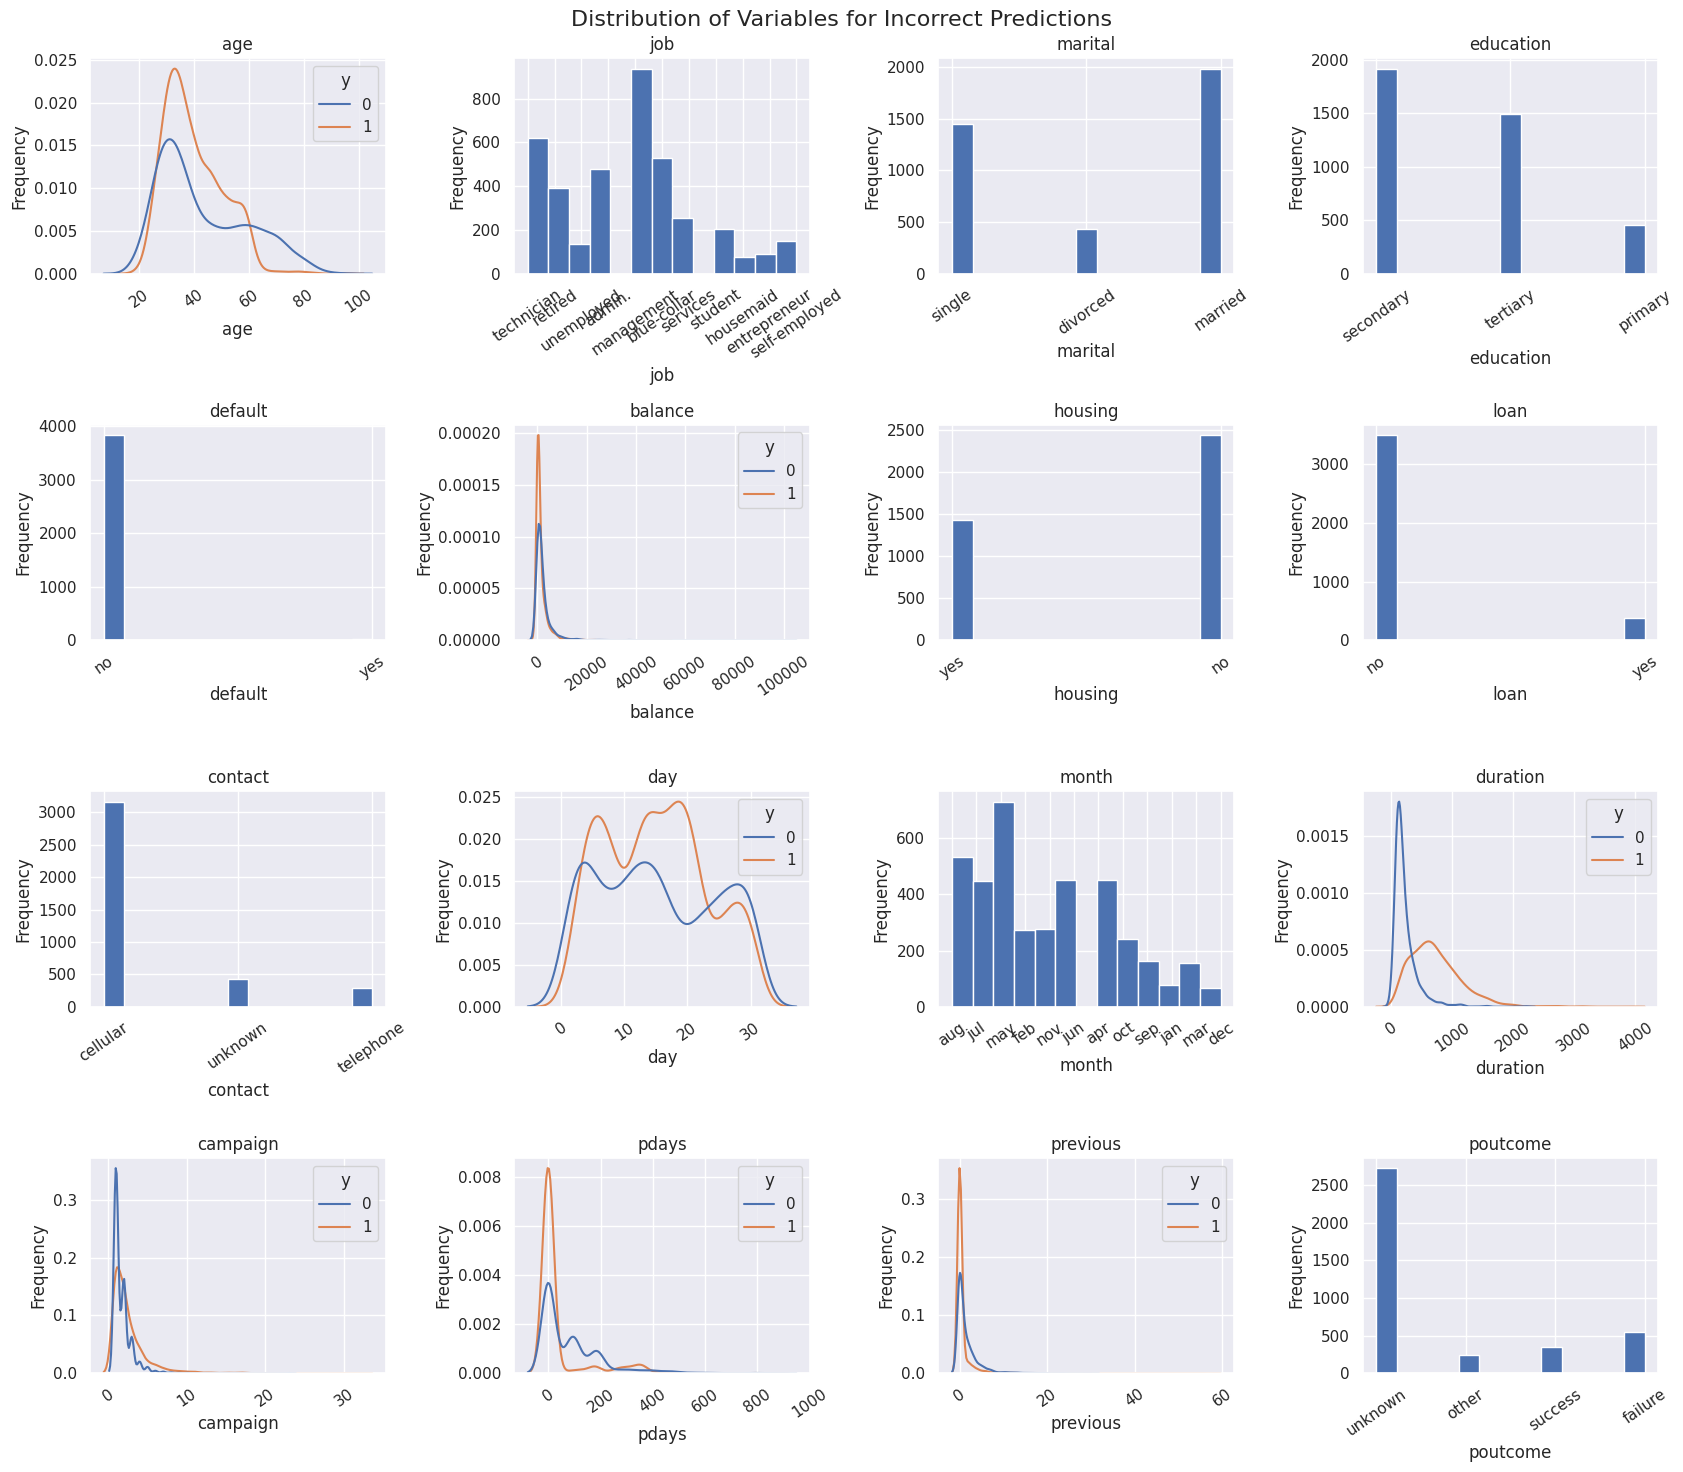

In [ ]:
# Plot one histogram for each variable in df_errors in the same figure
plt.figure(figsize=(17, 15))  # Adjust figure size as needed

for i, col in enumerate(df_errors.drop(['y', 'y_pred'], axis=1).columns):
    plt.subplot(4, 4, i + 1)  # Create subplots in a 4x4 grid
    if df_errors[col].dtype == 'int':
        sns.kdeplot(data=df_errors, x=col, hue='y')
    else:
      plt.hist(df_errors[col], bins='sturges')  # Adjust the number of bins as needed
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=35)

plt.suptitle('Distribution of Variables for Incorrect Predictions', fontsize=16)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Conclusion

Concluding this study, it is clear that the variables presented cannot provide a solid separation of classes.

The imbalance is heavy, but the techniques to correct it - *such as class weights and SMOTE* - were not sufficient to improve performance. This causes a problem for the model to find a pattern to properly classify the minority class 1 (converting customers) and perform better.

Given that there are too many observations where the customers did not convert, the variability of combinations that are labeled 0 is too large, overlaying and hiding the class 1 within it. Thus, the observations falling in this "common place" have similar probabilities for both sides, and that is where the model will fail. The observations are wrongly classified due to the imbalance, since the negative class has more strenght and creates more bias.


## Predictions over the Test Set
The best performing model was the Tuned Catboost, which is the fitted "model2". So we need to prepare the test dataset and make the final predictions and evaluation.

In [ ]:
# Preparing data for predictions
X_test, y_test = prepare_data(df_test)

In [ ]:
# Predict
test_prediction = model2.predict(X_test)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, test_prediction)  )
print ("Confusion Matrix : \n")
display(cm)

# Evaluate the model
print('----------- Test Set Restuls -----------:')

print(classification_report(y_test, test_prediction))
print('-------------------------------')
print('F1:', f1_score(y_test, test_prediction))
print('-------------------------------')
print('Accuracy:', accuracy_score(y_test, test_prediction))

Confusion Matrix : 



,0,1
0,7411,526
1,566,486


----------- Test Set Restuls -----------:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7937
           1       0.48      0.46      0.47      1052

    accuracy                           0.88      8989
   macro avg       0.70      0.70      0.70      8989
weighted avg       0.88      0.88      0.88      8989

-------------------------------
F1: 0.47093023255813954
-------------------------------
Accuracy: 0.8785181888975414


In [ ]:
obs = {'age': 37,
       'job': 'management',
       'marital': 'married',
       'education': 'tertiary',
       'default': 'no', #
       'balance': 100,
       'housing': 'no', #
       'loan': 'no', #
       'contact': 'cellular', #
       'day': 31, #
       'month': 'aug', #
       'duration': np.nan,
       'campaign': 2, #
       'pdays': 272, #
       'previous': 10,
       'poutcome': 'success',
       'y':99}

# Prediction
predict_single_entry(obs)

array([[0.28210575, 0.71789425]])

After finalizing the predictions and predicting a couple of *single observations*, we noticed that the variables that make more difference in the probabilities are `default`, `housing`, `loan`, `day`, `contact_cellular`, `contact_telephone`, `month`, `campaign`, `pdays`.

So, let's try a simpler model with these variables.

In [ ]:
# Only selected variables after evaluation
# df_train_selected = df_train_clean.drop(['age', 'education', 'day_of_week','contact', 'month', 'campaign','pdays'], axis=1)

df_train_selected = df_train_clean[['default', 'housing', 'loan', 'day', 'contact_cellular', 'contact_telephone', 'month', 'campaign', 'pdays','y']]

# Split X and y
Xs = df_train_selected.drop(['y'], axis=1)
ys = df_train_selected['y']

# Split Train and Validation
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs, ys, test_size=0.2, random_state=42)

model6 = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth = 5,
                           loss_function='Logloss',
                           border_count= 64,
                           l2_leaf_reg= 13,
                           class_weights=[1, 3],
                           early_stopping_rounds=50,
                           verbose=1000)
# train the model
model6.fit(Xs_train, ys_train)

prediction6 = model6.predict(Xs_val)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(ys_val, prediction6)  )
print ("\nConfusion Matrix : \n")
display(cm)

# Evaluate the model
print('***************************************')
print('Catboost Selected Variables 2:')
print('***************************************')
print(classification_report(y_test, test_prediction))
print('-------------------------------')
print('F1:', f1_score(y_test, test_prediction))
print('-------------------------------')
print('Accuracy:', accuracy_score(y_test, test_prediction))

0:	learn: 0.6588071	total: 8.1ms	remaining: 2.42s
299:	learn: 0.4401781	total: 2.4s	remaining: 0us

Confusion Matrix : 



,0,1
0,5959,417
1,420,391


***************************************
Catboost Selected Variables 2:
***************************************
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7937
           1       0.48      0.46      0.47      1052

    accuracy                           0.88      8989
   macro avg       0.70      0.70      0.70      8989
weighted avg       0.88      0.88      0.88      8989

-------------------------------
F1: 0.47093023255813954
-------------------------------
Accuracy: 0.8785181888975414


This is one of the best models, along with the **Tuned Catboost**.

## Grid Search

In [ ]:
# Define a CatBoost model with basic parameters
catboost_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    eval_metric='F1',
    class_weights=[1, 8],  # Adjust based on imbalance ratio (example for 89:11 imbalance)
    random_seed=42,
    verbose=False
)

# Define the parameter grid to test for `border_count` and `l2_leaf_reg`
param_grid = {
    'border_count': [32, 64, 128],        # Lower values can prevent overfitting
    'l2_leaf_reg': [1, 3, 5, 7, 9]        # Higher values add regularization
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1',         # Optimize for F1 score
    cv=5                  # 5-fold cross-validation
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
f1 = f1_score(y_val, y_pred, pos_label=1)
print(f"F1 Score for class 1 on the test set: {f1:.4f}")


## Functions from this notebook

In [ ]:
# Function to replace the variable data with the new categorized bins
def variable_to_category(data, variable, k):
  return pd.cut(data[variable], bins=k).astype(str)

In [ ]:
# Function to prepare the data for prediction
def prepare_data(dtf):
  '''
  Function to prepare the data for prediction. The steps are the same used to prepare the training data.
  * Input:
  dtf: dataframe

  * Output:
  data clean: dataframe with the cleaned data
  '''

  # Imports
  from feature_engine.encoding import OneHotEncoder
  from feature_engine.imputation import CategoricalImputer
  import category_encoders as ce

  # Drop NAs from variable jobs
  dtf = dtf.dropna(subset='job')

  # Simple Imputer for education
  imputer = CategoricalImputer(
      variables=['education'],
      imputation_method="frequent"  )

  # Fit and Transform
  imputer.fit(dtf)
  dtf = imputer.transform(dtf)

  # Input "unknown" for NAs in poutcome.
  dtf['poutcome'] = dtf['poutcome'].fillna('unknown')

  # Fill NAs with "unknown" in contact
  dtf['contact'] = dtf['contact'].fillna('unknown')

  # Binarizing default, housing, loan, and y
  dtf = dtf.replace({'no': 0, 'yes': 1})

  # Variable balance in 3 categories: <0 = 'negative, 0-median = 'avg', >median = 'over avg'
  dtf = (
      dtf
      .assign(balance = lambda x: np.where(x.balance < 0,
                                            'negative',
                                            np.where(x.balance < x.balance.median(),
                                                    'avg',
                                                    'over avg')
                                            )       )
  )

  # Instance OHR
  ohe = OneHotEncoder(variables=['marital', 'poutcome', 'education', 'contact', 'job', 'balance'], drop_last=True)

  # Fit
  ohe.fit(dtf)

  # Transform
  dtf = ohe.transform(dtf)

  # Move y to the first column
  dtf.insert(0, 'y', dtf.pop('y'))

  # Month to numbers
  dtf['month'] = dtf['month'].map({ 'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})

  # drop variable duration
  dtf = dtf.drop('duration', axis=1)

  # Transforming variable Age into bins
  # Using Sturges rule, where number of bins k = 1 + 3.3*log10(n)
  k = int( 1 + 3.3*np.log10(len(dtf)) )

  # Categorize age, balance, duration, previous, pdays
  for var in str.split('age,pdays,previous', sep=','):
    dtf[var] = variable_to_category(dtf, var, k=k)

  # CatBoost Encoding the dataset
  dtf = ce.CatBoostEncoder().fit_transform(dtf, dtf['y'])

  # Reindex to match columns from the fitted model
  # cols_order = ['y','default', 'housing', 'loan', 'day', 'contact_cellular', 'contact_telephone', 'month', 'campaign', 'pdays']

  cols_order = ['y', 'age', 'default', 'housing', 'loan', 'day', 'month', 'campaign','pdays', 'previous', 'marital_divorced', 'marital_single',
                'poutcome_unknown', 'poutcome_failure', 'poutcome_other', 'education_secondary', 'education_tertiary', 'contact_telephone',
                'contact_cellular', 'job_technician', 'job_student', 'job_unemployed', 'job_blue-collar', 'job_management', 'job_services', 'job_admin.',
                'job_retired', 'job_entrepreneur', 'job_housemaid', 'balance_over avg', 'balance_avg']

  # reindex
  dtf = dtf.reindex(columns=cols_order, fill_value=0)

  # Return
  return dtf.drop('y', axis=1), dtf['y']

In [ ]:
cols_order = ['y', 'age', 'default', 'housing', 'loan', 'day', 'month', 'campaign','pdays', 'previous', 'marital_divorced', 'marital_single',
                'poutcome_unknown', 'poutcome_failure', 'poutcome_other', 'education_secondary', 'education_tertiary', 'contact_telephone',
                'contact_cellular', 'job_technician', 'job_student', 'job_unemployed', 'job_blue-collar', 'job_management', 'job_services', 'job_admin.',
                'job_retired', 'job_entrepreneur', 'job_housemaid', 'balance_over avg', 'balance_avg']

In [ ]:
# Function to predict a single entry
def predict_single_entry(observation):
  '''
  This function takes in a list and returns a prediction whether the customer will or not submit a term direct deposit.
  * Input:
  - observation: dictionary
  * Output:
  - prediction probability: 0 or 1
  '''
  # dictionary to dataframe
  dfp = pd.DataFrame(observation, index=[0])

  # Prepare Data
  predictors, target = prepare_data(dfp)

  # Predict
  test_prediction = model2.predict_proba(predictors)

  # Return result
  return test_prediction